In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Estudo do filtro da mediana para background

In [3]:
video_path = '../videos/Cars.mp4'
video_output = '../videos/Cars_resultado.avi'

In [4]:
cap = cv2.VideoCapture(video_path)


In [5]:
hasframe, frame = cap.read()
frame.shape

(720, 1280, 3)

In [6]:
#Coletando 25 frames aleatórios para criar a imagem de fundo 
fourcc = cv2.VideoWriter_fourcc(*'XVID')   #Gravar o video de resultado - XVID formato
writer = cv2.VideoWriter(filename=video_output,fourcc=fourcc,fps=25,frameSize=(frame.shape[1], frame.shape[0]),isColor=True)

In [7]:
#Função para descobrir qual a quantidade de frames
cap.get(cv2.CAP_PROP_FRAME_COUNT)
#Gerando uma matriz de 25 numeros aleatórios
np.random.uniform(size=25)

array([0.08786184, 0.58983253, 0.75504711, 0.83066163, 0.38366359,
       0.26347587, 0.52254999, 0.05799515, 0.711355  , 0.7440693 ,
       0.09491103, 0.12678532, 0.63920057, 0.42168612, 0.80972155,
       0.81211138, 0.95456405, 0.07832539, 0.87543267, 0.55206663,
       0.51304065, 0.73321036, 0.39818014, 0.05665086, 0.81093299])

In [8]:
framesId = cap.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=25)
framesId

array([  45.41368004, 2689.47599517, 1988.73941128,  600.24494304,
       2472.37645929,  121.84692021, 1326.36791629, 1065.671593  ,
       1908.11913942, 2243.59692634,  550.06622925, 1059.80102121,
       2123.37939522,   98.32052405,  328.21495196, 1516.31479099,
       1017.80762601,  347.90484015, 2553.49844279, 1700.92356555,
       2672.22783561, 1441.03816599,  818.59021864,  271.79132347,
       1416.37375069])

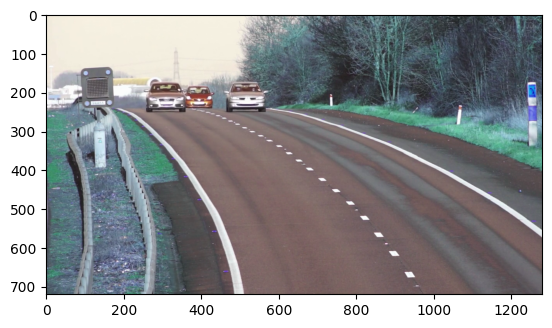

In [9]:
#Visualizar a imagem capturada dentre as 25 para construir o background
cap.set(cv2.CAP_PROP_POS_FRAMES,938)
_,frame_atual = cap.read()
plt.imshow(frame_atual)

In [10]:
#Coleta de 25 frames para fazer o background

frames_bg = []
for i in framesId:
    cap.set(cv2.CAP_PROP_POS_FRAMES,i)
    _,frame_atual = cap.read()
    frames_bg.append(frame_atual)


np.asarray(frames_bg).shape

(25, 720, 1280, 3)

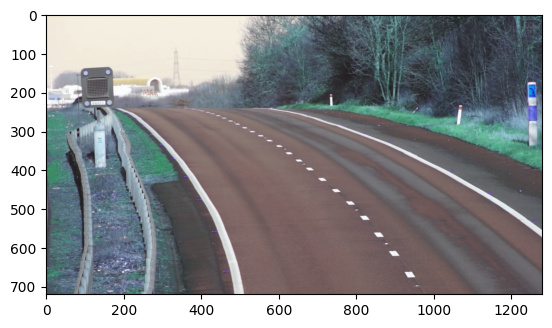

In [11]:
#Fazendo o cálculo da mediana
mediana_frame = np.median(frames_bg, axis=0).astype(dtype=np.uint8)
plt.imshow(mediana_frame)

In [12]:
#Salvar a imagem final
cv2.imwrite('bg_final_mediana.jpg',mediana_frame)

True

In [13]:
cap.set(cv2.CAP_PROP_POS_FRAMES,0)                           #resetando o inicio do frame
graymedian = cv2.cvtColor(mediana_frame,cv2.COLOR_BGR2GRAY)  #convertendo o bg da imagem para escala de cinza

In [ ]:
#Fazer loop

while(True):
    hasframe, frame = cap.read()

    if not hasframe:
        print('Error')
        break

    framegray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    diframe = cv2.absdiff(framegray,mediana_frame)
    #th,dframe = cv2.threshold(diframe,120,255,cv2.THRESH_BINARY)
    th,dframe = cv2.threshold(diframe,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    cv2.imshow('frame',dframe)
    writer.write(dframe)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

writer.release()
cap.release()

## Outras técnicas de pré processamento de imagens para detecção de movimento

In [2]:
import sys
from random import randint

In [28]:
#Cor que iremos definir para os textos que serão mostrados nos resultados
text_color = (randint(0,255), randint(0,255), randint(0,255))
border_color = (randint(0,255), randint(0,255), randint(0,255))
font = cv2.FONT_HERSHEY_SIMPLEX

In [29]:
video_path = '../videos\Traffic_4.mp4'
video_output = '../videos/traffic_4_resultado.avi'

In [30]:
#Tipos de algoritmos para construção de background
bgs_types = ['gmg','mog','mog2','knn','cnt']

In [57]:
#Criação dos kernels
# Usar essas funções na variavel kernel_morph --> cv2.MORPH_ELLIPSE, cv2.MORPH_RECT, cv2.MORPH_CROSS
def get_kernel(kernel_shape,kernel_morph):
    #if kernel_type == 'struct':
    kernel = cv2.getStructuringElement(kernel_morph,(kernel_shape,kernel_shape))
    #if kernel_type == 'erosion':
    #    kernel = cv2.getStructuringElement(kernel_morph,(kernel_shape,kernel_shape))
    #if kernel_type == 'ones':
    #    kernel = np.ones((kernel_shape,kernel_shape),np.uint8)
    #if kernel_type == 'closing':
    #    kernel = np.ones((kernel_shape,kernel_shape),np.uint8)
    
    return kernel



In [ ]:
get_kernel(kernel_shape=7,kernel_morph=cv2.MORPH_RECT)

In [64]:
#Aplicação do filtro na imagem
def getfilter(img,filter, kernel_shape,kernel_morph):
    if filter == 'closing':
        return cv2.morphologyEx(img,cv2.MORPH_CLOSE,get_kernel(kernel_shape,kernel_morph),iterations=2)
    if filter == 'opening':
        return cv2.morphologyEx(img,cv2.MORPH_OPEN,get_kernel(kernel_shape,kernel_morph),iterations=2)
    if filter == 'dilation':
        return cv2.dilate(img,get_kernel(kernel_shape,kernel_morph),iterations=2)
    if filter == 'erosion':
        return cv2.erode(img,get_kernel(kernel_shape,kernel_morph),iterations=2)




In [51]:
#Fazer a subtração do fundo

def get_bkgsub(bkgtype):
    if bkgtype == 'gmg':
        return cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames = 120, decisionThreshold = 0.8)
    if bkgtype == 'mog':
        return cv2.bgsegm.createBackgroundSubtractorMOG(history = 200, nmixtures = 5, backgroundRatio= 0.7, noiseSigma= 0)
    if bkgtype == 'mog2':
        return cv2.createBackgroundSubtractorMOG2(history = 500, detectShadows= True, varThreshold= 100)
    if bkgtype == 'knn':
        return cv2.createBackgroundSubtractorKNN(history= 200, dist2Threshold = 400, detectShadows=True)
    if bkgtype == 'cnt':
        return cv2.bgsegm.createBackgroundSubtractorCNT(minPixelStability = 15, useHistory = True, maxPixelStability=15*60, isParallel=True)

    #print('Detector inválido')
    #sys.exit(1)

In [106]:
cap = cv2.VideoCapture(video_path)
_,frame = cap.read()
sub = get_bkgsub(bgs_types[3])
bgs_type = bgs_types[3]

In [111]:
#Criando a função principal
def main():
    while cap.isOpened():
        ok,frame = cap.read()

        frame = cv2.resize(frame,(0,0),fx=0.5,fy=0.5)    #Redimensionando o video para diminuir o custo computacional 

        #Processo de filtragem, variar os filtros e elementos estruturantes para achar o melhor filtro
        bg_mask = sub.apply(frame)
        #fg_mask = getfilter(bg_mask,'erosion',3,cv2.MORPH_RECT)
        fg_mask = getfilter(bg_mask,'closing',3,cv2.MORPH_RECT)
        fg_mask = getfilter(fg_mask,'opening',3,cv2.MORPH_RECT)
        fg_mask = getfilter(fg_mask,'dilation',3,cv2.MORPH_RECT)
        res = cv2.bitwise_and(frame,frame,mask=fg_mask)

        cv2.putText(res,'Background Subtractor: ' + bgs_type, (5,25),font, 1,border_color,2,cv2.LINE_AA)
        cv2.putText(res,'Background Subtractor: ' + bgs_type, (5,25),font, 1,text_color,2,cv2.LINE_AA)

        if not ok:
            print("Error")
            break
        
        if bgs_type != 'mog'and bgs_type != 'gmg':
            cv2.imshow('Model',sub.getBackgroundImage())

        cv2.imshow('Frame',frame)
        cv2.imshow('BG Mask', bg_mask)
        cv2.imshow('FG Mask', fg_mask)
        cv2.imshow('Resultado',res)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            #cv2.destroyAllWindows()
            #cap.release()
            break



In [ ]:
main()

## Comparativo entre modelos - Qualidade

In [6]:
import csv

In [7]:
fp = open('comparativo.csv', mode='w')
writer = csv.DictWriter(fp,fieldnames=['Frame','Pixel Count',])
writer.writeheader()


19

In [8]:
#Cor que iremos definir para os textos que serão mostrados nos resultados
text_color = (randint(0,255), randint(0,255), randint(0,255))
border_color = (randint(0,255), randint(0,255), randint(0,255))
font = cv2.FONT_HERSHEY_SIMPLEX
text_size = 1.2
video_source = '../videos\people.mp4'
title_text_pos = (100,40)

bgs_types = ['gmg','mog','mog2','knn','cnt']

In [9]:
def getbgsub(bkgtype):
    if bkgtype == 'gmg':
        return cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames=10)
    if bkgtype == 'mog':
        return cv2.bgsegm.createBackgroundSubtractorMOG()
    if bkgtype == 'mog2':
        return cv2.createBackgroundSubtractorMOG2()
    if bkgtype == 'knn':
        return cv2.createBackgroundSubtractorKNN()
    if bkgtype == 'cnt':
        return cv2.bgsegm.createBackgroundSubtractorCNT()


In [10]:
cap = cv2.VideoCapture(video_source)
_,frame = cap.read()


In [11]:
bgsubtractor = []

for i, a in enumerate(bgs_types):
    bgsubtractor.append(getbgsub(a))

In [12]:
def main():
    framecount = 0
    while cap.isOpened():
        ok,frame = cap.read()

        if not ok:
            print("Error")
            break
        
        framecount +=1
        frame = cv2.resize(frame,(0,0),fx=0.2,fy=0.2)    #Redimensionando o video para diminuir o custo computacional 

        gmg = bgsubtractor[0].apply(frame)
        mog = bgsubtractor[1].apply(frame)
        mog2 = bgsubtractor[2].apply(frame)
        knn = bgsubtractor[3].apply(frame)
        cnt = bgsubtractor[4].apply(frame)

        #Contar a quantidade de pixels brancos
        gmgcount = np.count_nonzero(gmg)
        mogcount = np.count_nonzero(mog)
        mog2count = np.count_nonzero(mog2)
        knncount = np.count_nonzero(knn)
        cntcount = np.count_nonzero(cnt)

        #Criando linhas para o arquivo csv
        writer.writerow({'Frame':'GMG','Pixel Count':gmgcount})
        writer.writerow({'Frame':'MOG','Pixel Count':mogcount})
        writer.writerow({'Frame':'MOG2','Pixel Count':mog2count})
        writer.writerow({'Frame':'KNN','Pixel Count':knncount})
        writer.writerow({'Frame':'CNT','Pixel Count':cntcount})

        cv2.putText(gmg,'GMG',title_text_pos,font,text_size,text_color,2,cv2.LINE_AA)
        cv2.putText(mog,'MOG',title_text_pos,font,text_size,text_color,2,cv2.LINE_AA)
        cv2.putText(mog2,'MOG2',title_text_pos,font,text_size,text_color,2,cv2.LINE_AA)
        cv2.putText(knn,'KNN',title_text_pos,font,text_size,text_color,2,cv2.LINE_AA)
        cv2.putText(cnt,'CNT',title_text_pos,font,text_size,text_color,2,cv2.LINE_AA)

        cv2.imshow('Frame',frame)
        cv2.imshow('GMG',gmg)
        cv2.imshow('MOG',mog)
        cv2.imshow('MOG2',mog2)
        cv2.imshow('KNN',knn)
        cv2.imshow('CNT',cnt)

        cv2.moveWindow('Frame',0,0)
        cv2.moveWindow('GMG',0,250)
        cv2.moveWindow('MOG',0,500)
        cv2.moveWindow('MOG2',719,0)
        cv2.moveWindow('KNN',719,250)
        cv2.moveWindow('CNT',719,500)
        

        if cv2.waitKey(1) & 0xFF == ord('q'):
            #cv2.destroyAllWindows()
            #cap.release()
            break
        
        #k = cv2.waitKey(0) & 0xff
        #if k == 27:
            #cv2.destroyAllWindows()
            #cap.release()
        #    break



In [13]:
main()

Error


In [14]:
import pandas as pd

In [15]:
avaliacao = pd.read_csv('../detect_mov\comparativo.csv')
avaliacao

,Frame,Pixel Count
0,GMG,0
1,MOG,0
2,MOG2,82944
3,KNN,82944
4,CNT,82944
...,...,...
706,MOG,4088
707,MOG2,9378
708,KNN,9105
709,CNT,7292


In [16]:
resultado_avaliacao = avaliacao.groupby(['Frame']).sum()
resultado_avaliacao.sort_values(['Pixel Count'],ascending=False)

,Pixel Count
Frame,
CNT,2510306
KNN,1713110
MOG2,1374671
MOG,622919
GMG,464493


## Comparativo entre modelos - Desempenho

In [5]:
TEXTCOLOR = (randint(0, 255), randint(0, 255), randint(0, 255))
BORDERCOLOR = (randint(0, 255), randint(0, 255), randint(0, 255))
FONT = cv2.FONT_HERSHEY_SIMPLEX
VIDEO_SOURCE = "videos/people.mp4"

BGS_TYPES = ["GMG", "MOG", "MOG2", "KNN", "CNT"]
BGS_TYPE = BGS_TYPES[0]
# GMG - 39
# MOG - 28
# MOG2 - 17
# KNN - 16
# CNT - 14

def getBGSubtractor(BGS_TYPE):
    if BGS_TYPE == "GMG":
        return cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames=10)
    if BGS_TYPE == "MOG":
        return cv2.bgsegm.createBackgroundSubtractorMOG()
    if BGS_TYPE == "MOG2":
        return cv2.createBackgroundSubtractorMOG2()
    if BGS_TYPE == "KNN":
        return cv2.createBackgroundSubtractorKNN()
    if BGS_TYPE == "CNT":
        return cv2.bgsegm.createBackgroundSubtractorCNT()
    print("Unknown createBackgroundSubtractor type")
    sys.exit(1)

cap = cv2.VideoCapture(VIDEO_SOURCE)
bg_subtractor = getBGSubtractor(BGS_TYPE)
e1 = cv2.getTickCount()

def main():
    frame_number = -1
    while (cap.isOpened):
        ok, frame = cap.read()

        if not ok:
          print('Erro')
          break

        frame_number += 1

        bg_mask = bg_subtractor.apply(frame)
        res = cv2.bitwise_and(frame, frame, mask=bg_mask)

        cv2.imshow('Frame', frame)
        cv2.imshow('Mask', res)

        if cv2.waitKey(1) & 0xFF == ord("q") or frame_number > 250:
            break

    e2 = cv2.getTickCount()
    t = (e2 - e1) / cv2.getTickFrequency()
    print(t)

main()

Erro
0.0002611
